<a href="https://colab.research.google.com/github/Himagination/All_Datasets/blob/master/DCGANs_Generate_Handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

- Implement Deep Convolutional Generative Adversial Networks(DCGAN) to generate Handwritten Digits using MNIST dataset.
- Main Features of DCGAN:
  - Use Convolutions without any Pooling Layers.
  - Use Batchnorm in both generator and the discriminator.
  - Don't use fully connected hidden layers.
  - Use ReLU activation inthe generator for all layers except for the output which uses a Tanh activation.
  - Use LeakyReLU activation in the discriminator for all layers except for the output which does not use an activation.

## Imports

In [28]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Utility function

In [29]:
def show_tensor_images(image_tensor, 
                       num_images=25, 
                       size=(1, 28, 28)):
  image_tensor = (image_tensor + 1)/2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()

## Generator

- DCGAN use convolutions which doesn't depends on the number of pixels on an image. Hence, instead of passing the image dimension as an argument, number of image channels is passed as an argument to the Generator.
- The Generator will consist of 4 layers(3 hidden layers + 1 Output layer)

In [38]:
class Generator(nn.Module):
  def __init__(self, 
               z_dim=10, 
               im_chan=1, 
               hidden_dim=64):
    super(Generator, self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.make_gen_block(z_dim, hidden_dim * 4), 
        self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1), 
        self.make_gen_block(hidden_dim * 2, hidden_dim), 
        self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True)
    )

  def make_gen_block(self, 
                     input_channels, 
                     output_channels, 
                     kernel_size=3, 
                     stride=2, 
                     final_layer=False):
    # Do a transposed convolution using the given parameters
    # Do a batchnorm, except for the last layer
    # Follow each batchnorm with a ReLU activation
    # If its the final layer, use a Tanh activation

    if not final_layer:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, 
                             output_channels, 
                             kernel_size, 
                             stride),
          nn.BatchNorm2d(output_channels), 
          nn.ReLU(inplace=True)
      )
    else:
      return nn.Sequential(
          nn.ConvTranspose2d(input_channels, 
                             output_channels, 
                             kernel_size, 
                             stride), 
          nn.Tanh()
      )

  def forward(self, noise):
      x = noise.view(len(noise), self.z_dim, 1, 1)
      return self.gen(x)

def get_noise(n_samples, z_dim, device):
  return torch.randn(n_samples, z_dim).to(device)

## Discriminator

In [46]:
class Discriminator(nn.Module):
  def __init__(self, 
               im_chan=1, 
               hidden_dim=16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.make_disc_block(im_chan, hidden_dim), 
        self.make_disc_block(hidden_dim, hidden_dim * 2), 
        self.make_disc_block(hidden_dim * 2, 1, final_layer=True)
    )

  def make_disc_block(self, 
                      input_channels, 
                      output_channels, 
                      kernel_size=4, 
                      stride=2, 
                      final_layer=False):
    # Add a convolutional layer using givenm parameters
    # Do a batchnorm, except for the last layer
    # Follow each batchnorm with a LeakyReLU activation

    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(input_channels, 
                    output_channels, 
                    kernel_size, 
                    stride), 
          nn.BatchNorm2d(output_channels), 
          nn.LeakyReLU(0.2, inplace=True)
      )

    else:
      return nn.Sequential(
          nn.Conv2d(input_channels, 
                    output_channels, 
                    kernel_size, 
                    stride)
      )

  def forward(self, image):
    disc_pred = self.disc(image)
    return disc_pred.view(len(disc_pred), -1)

## Training

- **Parameters**

  - criterion: Binary Cross Entropy
  - n_epochs
  - z_dim: Dimension of noise vector
  - display_step: how often to display/visualize the images
  - batch_size
  - lr: The Learning Rate
  - beta_1, beta_2: Momentum term
  - Device

- **Transform:** Transform image values to be between -1 and 1

- **Create DataLoader**

- **Initialize Generator, Discriminator, Optimizers**

- **Train the Model**

In [47]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [48]:
transform = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, ), (0.5, ))
])

In [49]:
dataloader = DataLoader(
    MNIST('.', download=True, transform=transform), 
    batch_size=batch_size, 
    shuffle=True
)

In [50]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), 
                           lr=lr, 
                           betas=(beta_1, beta_2))
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

In [51]:
def weight_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    torch.nn.init.normal_(m.weight, 0.0, 0.02)
    torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weight_init)
disc = disc.apply(weight_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.8871395736932759 Discriminator loss: 0.5529396178722378


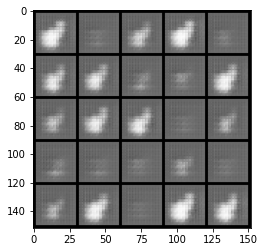

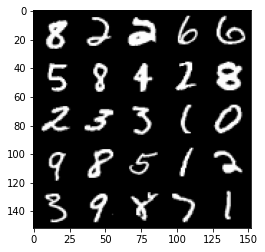

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 1.574450055867434 Discriminator loss: 0.37929780381917955


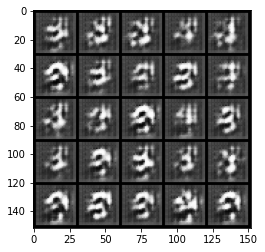

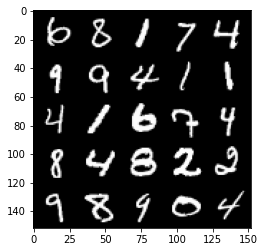

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 1.1244619030654428 Discriminator loss: 0.5280208907723424


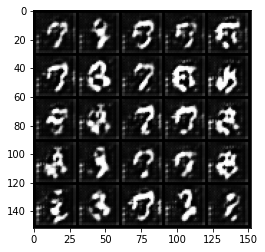

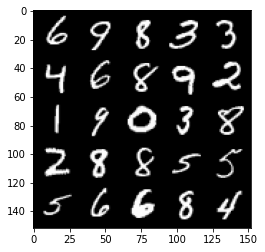

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.9419403590261942 Discriminator loss: 0.5779010906219482


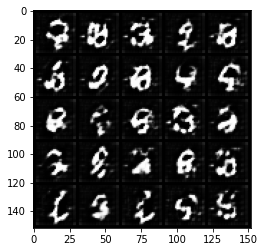

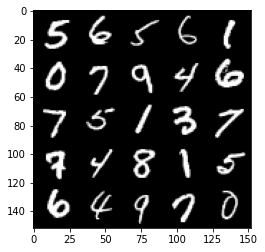

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.8800297324657448 Discriminator loss: 0.609040976881981


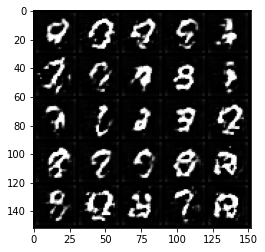

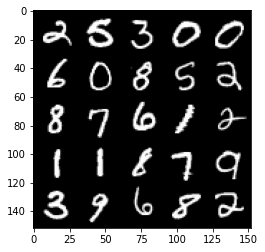

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.8292213656902306 Discriminator loss: 0.6280827443599702


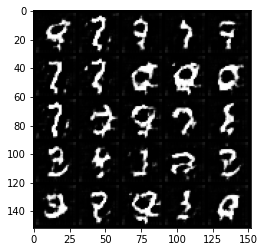

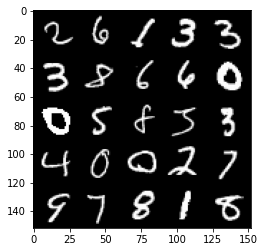

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.8172783930301663 Discriminator loss: 0.6367014694213865


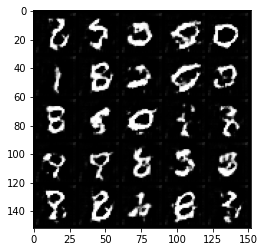

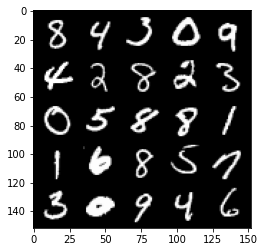

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.819677922606468 Discriminator loss: 0.645005550742149


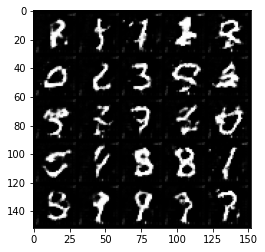

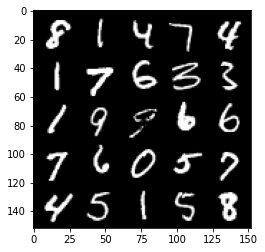

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.8036897473335265 Discriminator loss: 0.6506986953020096


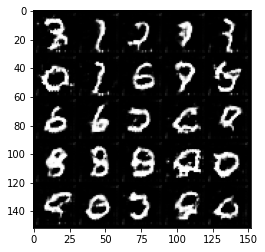

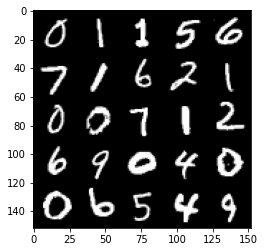

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.7985839125514038 Discriminator loss: 0.653743529200554


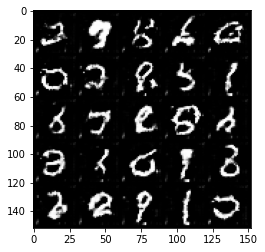

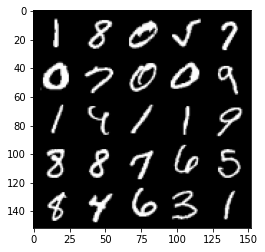

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.7848431031703943 Discriminator loss: 0.6619138382673264


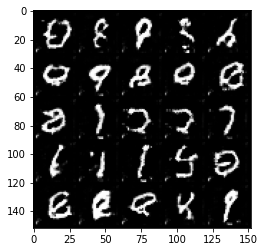

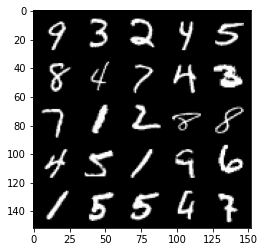

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.7746202920079236 Discriminator loss: 0.666388440012932


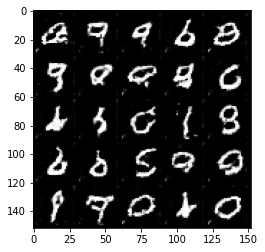

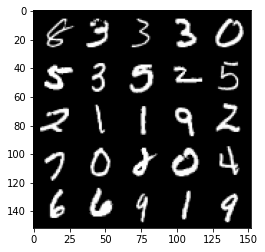

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7699004113078114 Discriminator loss: 0.6697283016443264


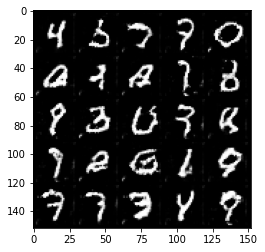

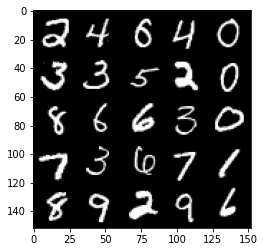

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.7628132865428922 Discriminator loss: 0.6754692741632458


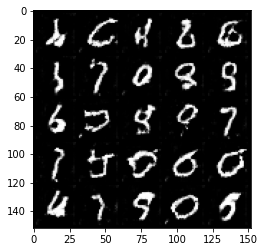

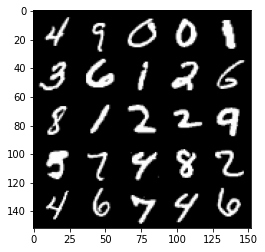

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7542942787408827 Discriminator loss: 0.6784132535457611


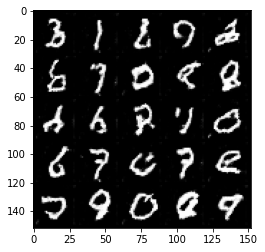

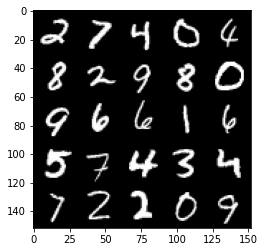

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7494489239454268 Discriminator loss: 0.6805856326818459


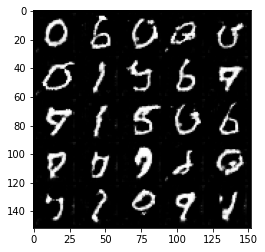

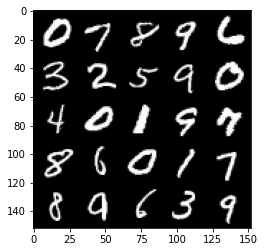

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7451798456311222 Discriminator loss: 0.6824740668535231


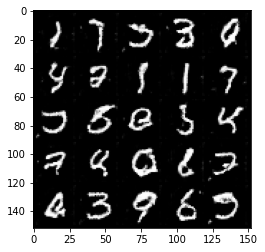

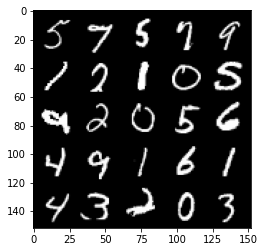

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7447420396804811 Discriminator loss: 0.684093386292458


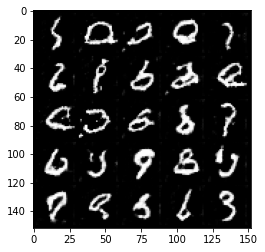

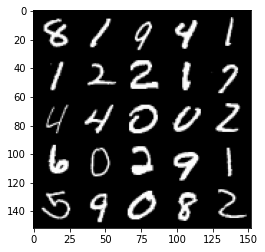

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7385984122753144 Discriminator loss: 0.684435027003289


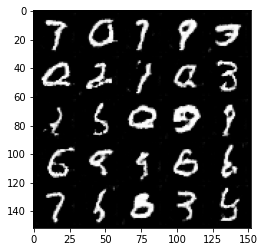

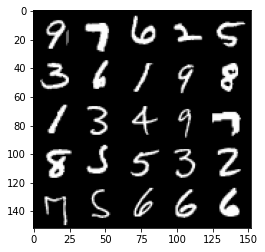

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.736266894757748 Discriminator loss: 0.6864419816732403


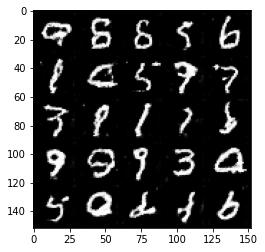

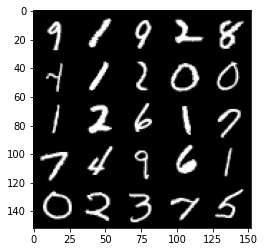

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.73403990572691 Discriminator loss: 0.6866894251108175


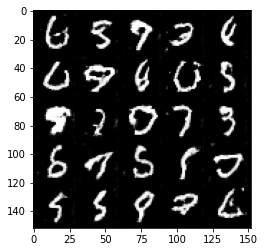

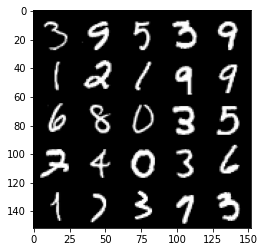

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.7332246207594866 Discriminator loss: 0.6878067337274548


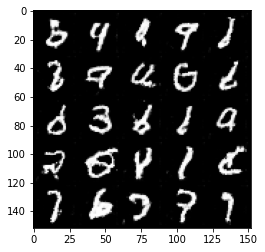

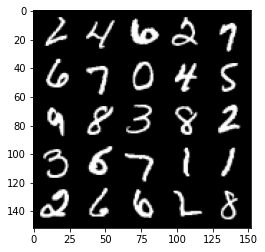

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.7307055438160891 Discriminator loss: 0.6873799755573275


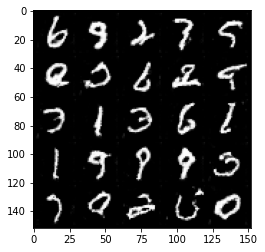

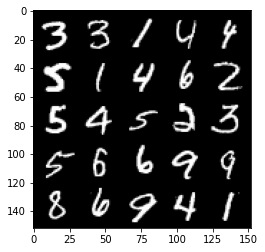

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.7284637090563773 Discriminator loss: 0.6901998302936552


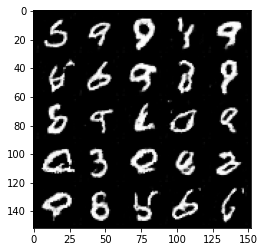

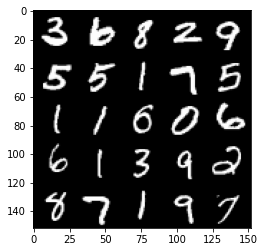

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.7294342101812369 Discriminator loss: 0.6907321447134016


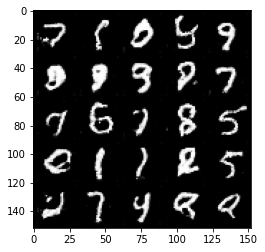

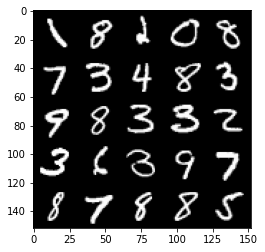

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.7232378032803539 Discriminator loss: 0.6926856330633163


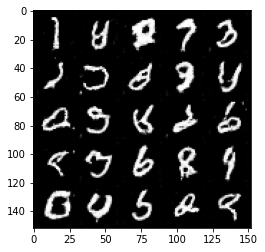

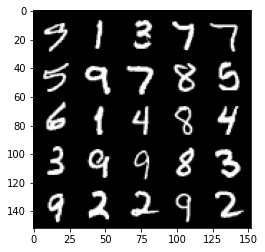

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.7218562395572661 Discriminator loss: 0.6918588055372243


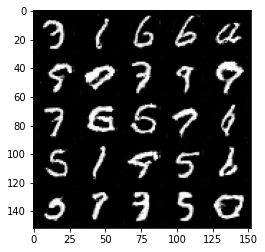

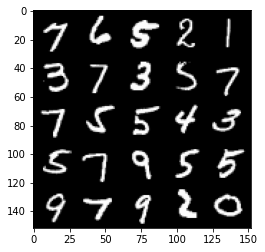

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.7218591079115867 Discriminator loss: 0.692765197753906


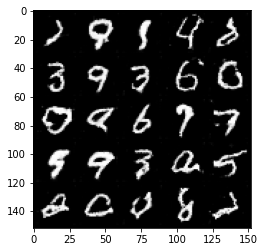

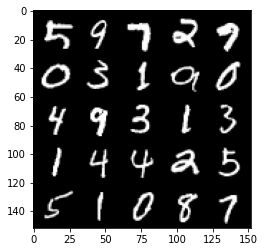

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.719005875706673 Discriminator loss: 0.6948127490282069


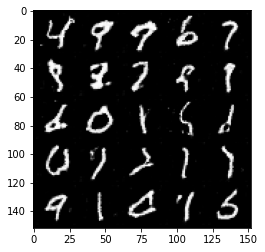

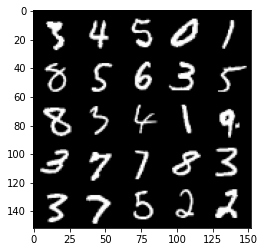

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.7147544569969176 Discriminator loss: 0.6948424105644223


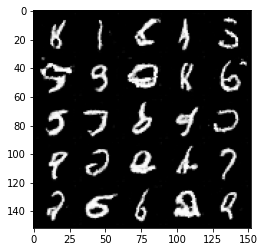

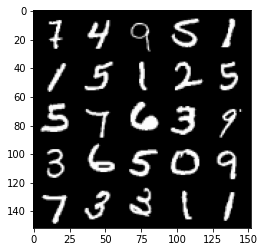

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.7093701654076573 Discriminator loss: 0.6968431925773625


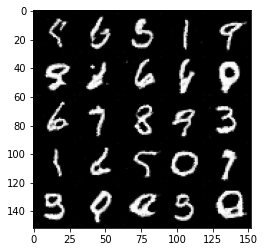

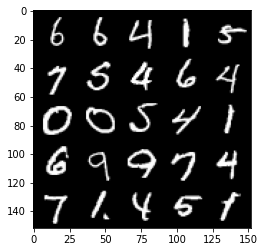

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.7122035449743271 Discriminator loss: 0.6953644061088557


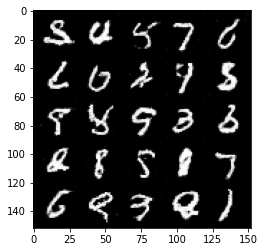

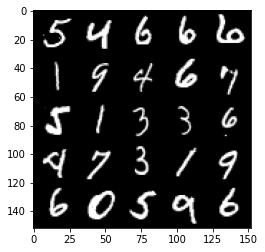

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.7101005825400347 Discriminator loss: 0.6952488703727733


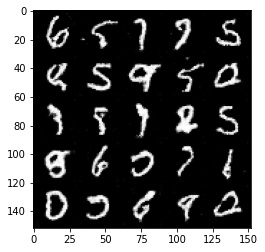

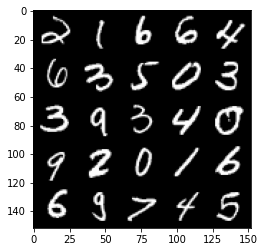

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.7085369210243222 Discriminator loss: 0.6946233355999002


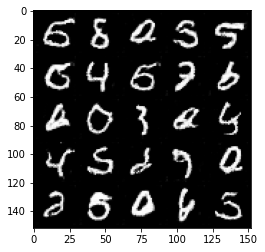

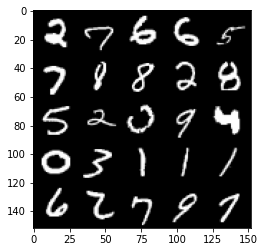

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.7110070178508755 Discriminator loss: 0.6943669939041132


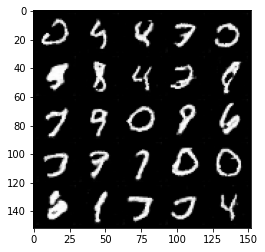

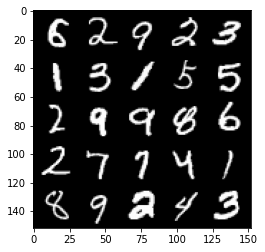

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.7072207279205325 Discriminator loss: 0.6954570291042328


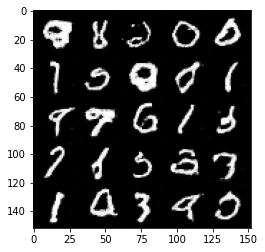

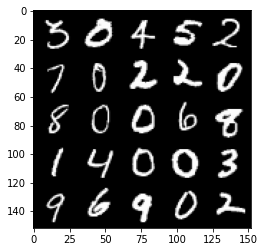

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.7057042369842532 Discriminator loss: 0.6946849012374877


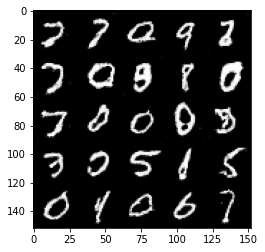

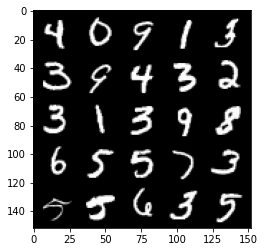

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.7060550435781475 Discriminator loss: 0.6953412570953366


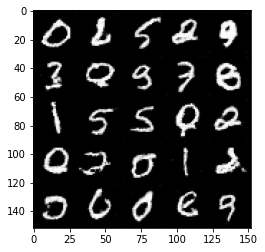

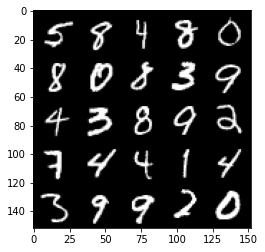

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.7059296862483022 Discriminator loss: 0.6959612379074098


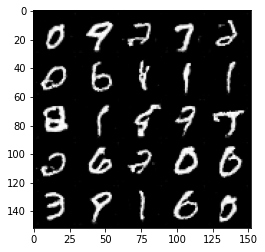

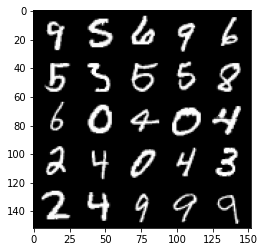

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.7048054671287537 Discriminator loss: 0.6956662974357606


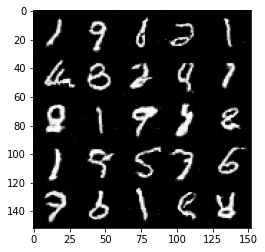

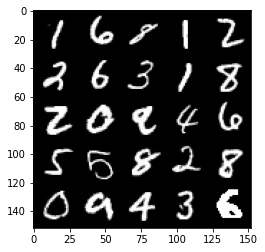

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.7034318648576725 Discriminator loss: 0.695121847510338


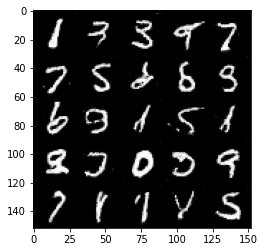

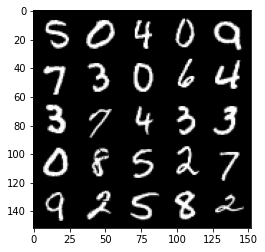

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.7026840835809709 Discriminator loss: 0.6959042741060251


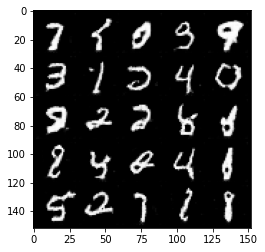

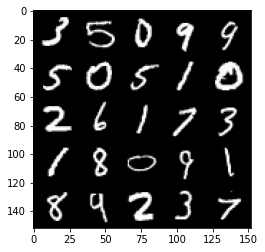

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.7029732123613364 Discriminator loss: 0.6955227243900297


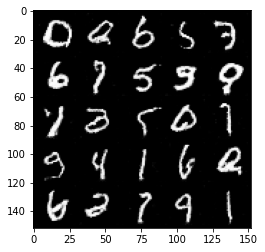

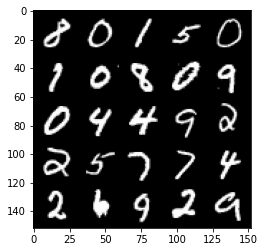

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.7008967532515523 Discriminator loss: 0.6964547840356822


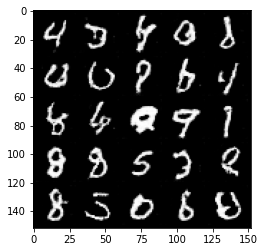

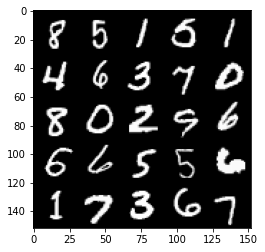

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.7019187582731256 Discriminator loss: 0.695284101605416


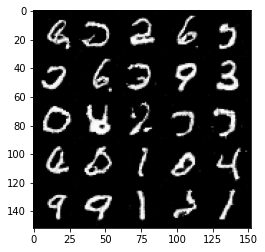

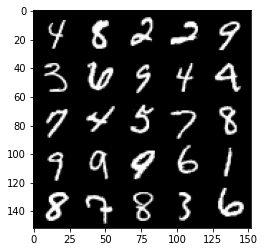

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.7005529574155808 Discriminator loss: 0.6962963442802432


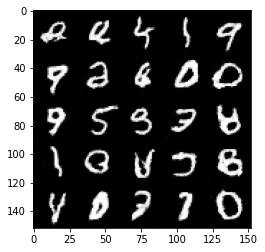

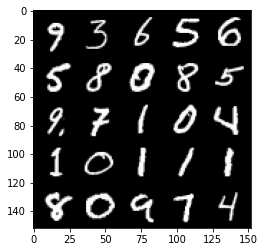

In [52]:
n_epochs = 50
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
  for real, _ in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)
    # Update Discriminator
    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size, z_dim, device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, 
                               torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, 
                               torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    # Keep track of the average discriminator loss
    mean_discriminator_loss += disc_loss.item() / display_step
    # Upgrade gradients
    disc_loss.backward(retain_graph=True)
    # Update optimizer
    disc_opt.step()

    # Update Generator
    gen_opt.zero_grad()
    fake_noise_2 = get_noise(cur_batch_size, 
                             z_dim, 
                             device)
    fake_2 = gen(fake_noise_2)
    disc_fake_pred = disc(fake_2)
    gen_loss = criterion(disc_fake_pred, 
                         torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    # Keep track of the average generator loss
    mean_generator_loss += gen_loss.item() / display_step

    # Visualization code
    if cur_step % display_step == 0 and cur_step > 0:
      print(f"Step {cur_step}: Generator loss: {mean_generator_loss} Discriminator loss: {mean_discriminator_loss}")
      show_tensor_images(fake)
      show_tensor_images(real)
      mean_generator_loss = 0
      mean_discriminator_loss = 0
    cur_step += 1